## Create a Team of Agents to do Market Research for your Product Developement

This notebook draws inspiration from the paper [AutoGen: Enabling Next-Gen LLM Applications via Multi-Agent Conversation](https://arxiv.org/abs/2308.08155) by Wu et al., and the examples from [LangGraph](https://github.com/langchain-ai/langgraph/tree/main/examples/multi_agent). In this notebook, you will construct a Market Research Team and learn the following:

- How to define tools for agents. You will use the following tools:
  - [Taviliy](https://tavily.com/) for web search, get your [API key here](https://app.tavily.com/home).
  - [Exa](https://exa.ai/search), after account login, get your [API key here](https://docs.exa.ai/reference/getting-started-with-python). To find the exact content you're looking for on the web using embeddings-based search.  
  - [SerpApi here](https://serpapi.com/), after account login, get your [API key](https://serpapi.com/dashboard) to do look for existing patents.
  - Tools to access and write to a `.txt` file.
- How to define utilities to help create the graph.
- How to create a team supervisor and the team of agents.


</br>

## LangGraph
You will be using [LangGraph](https://langchain-ai.github.io/langgraph/) for this. LangGraph is a library designed for building stateful, multi-actor applications with LLMs, facilitating the creation of agent and multi-agent workflows.

LangGraph supports the definition of flows that involve `cycles`, which are crucial for most __agentic architectures__. It is a low-level framework and provides you, therefore, fine-grained control over both the flow and state of your application.

LangGraph is inspired by [Pregel](https://research.google/pubs/pub37252/) and [Apache Beam](https://beam.apache.org/). The public interface draws inspiration from [NetworkX](https://networkx.org/documentation/latest/).

</br>

### Key Features

- __Cycles and Branching__: Implement loops and conditionals in your apps.
- __Persistence__: Automatically save state after each step in the graph. Pause and resume the graph execution at any point to support error recovery, human-in-the-loop workflows, time travel and more.
- __Human-in-the-Loop__: Interrupt graph execution to approve or edit next action planned by the agent.
- __Streaming Support__: Stream outputs as they are produced by each node (including token streaming).
- __Integration with LangChain__: LangGraph integrates seamlessly with [LangChain](https://www.langchain.com/) and [LangSmith](https://docs.smith.langchain.com/), but does not require them.

# Install Dependencies

In [ ]:
!pip install -q langchain==0.2.12 \
                langgraph==0.1.19 \
                langchain_community==0.2.10 \
                langchain_experimental==0.0.63 \
                langchain_openai==0.1.20 \
                langchain_fireworks==0.1.7 \
                python-dotenv==1.0.1 \
                google-search-results==2.4.2 \
                exa-py==1.0.17

# Imports

In [ ]:
# Basic imports
import os
import functools
import operator
from tempfile import TemporaryDirectory
from pathlib import Path
from typing import Annotated, List, Dict, Optional
from typing_extensions import TypedDict

# LangChain & LangGraph imports
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_fireworks import ChatFireworks
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_openai import ChatOpenAI
from langchain_openai.chat_models import ChatOpenAI
from langgraph.graph import END, StateGraph, START

# Display the graph
from IPython.display import Image, display

# API access
from dotenv import load_dotenv
load_dotenv()

True

# API Setup

In [ ]:
# Setup .env file via the terminal
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
LANGCHAIN_API_KEY = os.getenv('LANGCHAIN_API_KEY')
TAVILY_API_KEY = os.getenv('TAVILY_API_KEY')
serp_api_key = os.getenv("SERPAPI_API_KEY")
exa_api_key = os.getenv("EXA_API_KEY")

# Uncomment if you want to use Fireworks instead of OpenAI
# FIREWORKS_API_KEY = os.getenv('FIREWORKS_API_KEY')

In [ ]:
# Tracking via LangSmith
LANGCHAIN_API_KEY = os.getenv("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"


###### ATT ######
# The above API is for US-accounts, if you have an EU account you have use this one:
# os.environ["LANGCHAIN_ENDPOINT"] = "https://eu.api.smith.langchain.com/"


project_name = "Market Research Team"  # Update with your project name
os.environ["LANGCHAIN_PROJECT"] = project_name  # Optional: "default" is used if not set


# Define a Persistent Working Directory

In [ ]:
# Define a persistent working directory
WORKING_DIRECTORY = Path("/content/working_directory")

# Ensure the working directory exists
if not WORKING_DIRECTORY.exists():
    WORKING_DIRECTORY.mkdir(parents=True)
    print(f"Created working directory: {WORKING_DIRECTORY}")
else:
    print(f"Working directory already exists: {WORKING_DIRECTORY}")


Working directory already exists: /content/working_directory


# Create Tools

Here you will create the tools for your agents. You can extend your agents [toolbox](https://python.langchain.com/v0.2/docs/concepts/#tools) as you wish.
The `@tool` decorator is the simpliest way of defining a custom tool. Note that you __need__ to define a `docstring` as the tool's description.

</br>

__Note of caution__:

The document writing and file-access tools gives your agents access to your file-system, this can be unsafe.


In [ ]:
# Load SerpAPI Search Wrapper from LangChain

from langchain_community.utilities import SerpAPIWrapper
from exa_py import Exa
import json
from typing import List


@tool("patent_search")
def patent_search(query: str) -> str:
    """Search with Google SERP API by a query to fine news about patents related to the query."""
    params = {
        "engine": "google_patents",
        "gl": "us",
        "hl": "en",
        }
    patent_search = SerpAPIWrapper(params=params, serpapi_api_key=serp_api_key)
    return patent_search.run(query)


@tool("exa_search")
def exa_search(question: str) -> str:
    """Tool using Exa's Python SDK to run semantic search and return result highlights."""
    exa = Exa(exa_api_key)

    response = exa.search_and_contents(
        question,
        type="neural",
        use_autoprompt=True,
        num_results=3,
        highlights=True
    )

    results = []
    for idx, eachResult in enumerate(response.results):
        result = {
            "Title": eachResult.title,
            "URL": eachResult.url,
            "Highlight": "".join(eachResult.highlights)
        }
        results.append(result)

    return json.dumps(results)

# Load Tavily Search Wrapper from LangChain
tavily_tool = TavilySearchResults(
    max_results= 5,
    search_depth = "advanced"
    )


########## Document Tools ##########
@tool
def create_outline(
    points: Annotated[List[str], "List of main points or sections."],
    file_name: Annotated[str, "File path to save the outline."],
) -> Annotated[str, "Path of the saved outline file."]:
    """Create and save an outline."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        for i, point in enumerate(points):
            file.write(f"{i + 1}. {point}\n")
    return f"Outline saved to {file_name}"


@tool
def read_document(
    file_name: Annotated[str, "File path to save the document."],
    start: Annotated[Optional[int], "The start line. Default is 0"] = None,
    end: Annotated[Optional[int], "The end line. Default is None"] = None,
) -> str:
    """Read the specified document."""
    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()
    if start is not None:
        start = 0
    return "\n".join(lines[start:end])


@tool
def write_document(
    content: Annotated[str, "Text content to be written into the document."],
    file_name: Annotated[str, "File path to save the document."],
) -> Annotated[str, "Path of the saved document file."]:
    """Create and save a text document."""
    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.write(content)
    return f"Document saved to {file_name}"


@tool
def edit_document(
    file_name: Annotated[str, "Path of the document to be edited."],
    inserts: Annotated[
        Dict[int, str],
        "Dictionary where key is the line number (1-indexed) and value is the text to be inserted at that line.",
    ],
) -> Annotated[str, "Path of the edited document file."]:
    """Edit a document by inserting text at specific line numbers."""

    with (WORKING_DIRECTORY / file_name).open("r") as file:
        lines = file.readlines()

    sorted_inserts = sorted(inserts.items())

    for line_number, text in sorted_inserts:
        if 1 <= line_number <= len(lines) + 1:
            lines.insert(line_number - 1, text + "\n")
        else:
            return f"Error: Line number {line_number} is out of range."

    with (WORKING_DIRECTORY / file_name).open("w") as file:
        file.writelines(lines)

    return f"Document edited and saved to {file_name}"


# Create Agent and Team Supervisor

In [ ]:
def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += "\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason! You are one of the following team members: {team_members}."
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools, handle_parsing_errors=True)
    return executor


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}


def create_team_supervisor(llm: ChatOpenAI, system_prompt, members) -> str:
    """An LLM-based router."""
    options = ["FINISH"] + members
    function_def = {
        "name": "route",
        "description": "Select the next role.",
        "parameters": {
            "title": "routeSchema",
            "type": "object",
            "properties": {
                "next": {
                    "title": "Next",
                    "anyOf": [
                        {"enum": options},
                    ],
                },
            },
            "required": ["next"],
        },
    }
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system_prompt),
            MessagesPlaceholder(variable_name="messages"),
            (
                "system",
                "Given the conversation above, who should act next?"
                " Or should we FINISH? Select one of: {options}",
            ),
        ]
    ).partial(options=str(options), team_members=", ".join(members))
    return (
        prompt
        | llm.bind_functions(functions=[function_def], function_call="route")
        | JsonOutputFunctionsParser()
    )

# Create the Agents and Graph

Here you create the agents you can also combine different LLMs to do your tasks. This might be beneficial because for specific tasks some LLMs might perform better than others or be less costly than others.

First you have to define the `graph state`. And then you can create your agents which can access the tools created before.

## Define Graph State

In [ ]:
# Define team graph state
class ResearchTeamState(TypedDict):
    # This tracks the team's conversation internally
    messages: Annotated[List[BaseMessage], operator.add]
    # This provides each worker with context on the others' skill sets
    team_members: str
    # This is how the supervisor tells langgraph who has to work next
    next: str
    # This tracks the shared directory state
    current_files: str

Next, you have a helper function that will run before each worker agent begins their task. This function ensures that the agents are more aware of the current state of the working directory.


## Helper Function for Dictory Access

In [ ]:
def prelude(state):
    """
    A helper function that prepares the state for each worker agent by ensuring the working directory exists
    and listing the files present in it.

    Args:
        state (dict): The current state to be updated with information about the files in the working directory.

    Returns:
        dict: The updated state with a key "current_files" containing a message about the files in the directory.
              If no files are present, the message will indicate that no files have been written.
    """

    written_files = []
    if not WORKING_DIRECTORY.exists():
        WORKING_DIRECTORY.mkdir(parents=True)
    try:
        written_files = [
            f.relative_to(WORKING_DIRECTORY) for f in WORKING_DIRECTORY.rglob("*")
            if f.is_file()
        ]
    except Exception as e:
        print(f"Error reading files: {e}")
    if not written_files:
        return {**state, "current_files": "No files written."}
    return {
        **state,
        "current_files": "\nBelow are files your team has written to the directory:\n"
        + "\n".join([f" - {f}" for f in written_files]),
    }

Now you can initialize your LLM. You can also use another LLM, for instance via [Fireworks](https://fireworks.ai/) works seemlessly with this LangGraph setting instead of OpenAI. For this, you just need to get the API key and if you want to use, for instance, the `Llama 3.1 70B` model, you how have to initialize your LLM as follows:

```python
from langchain_fireworks import ChatFireworks

llm = ChatFireworks(
    model="accounts/fireworks/models/llama-v3p1-70b-instruct",
    temperature=0
)


## Init LLM

In [ ]:
######## Initialize the LLM ########
llm = ChatOpenAI(model="gpt-4o")

# Define the Agents

In [ ]:
web_search_agent = create_agent(
    llm,
    [tavily_tool],
    """You are a research assistant who can search for up-to-date info using the
    Tavily Search Engine.""",
)
search_node = functools.partial(agent_node, agent=web_search_agent, name="Search")

exa_search_agent = create_agent(
    llm,
    [exa_search],
    """You are a research assistant who can search for all recent info on Exa Search
    your response should clearly articulate the key points you found.""",
)
exa_search_node = functools.partial(agent_node, agent=web_search_agent, name="ExaSearch")


patent_search_agent = create_agent(
    llm,
    [patent_search],
    """You are a market research assistant, very knowledgeable in patent research
    to find up-to-date info about patents using the Google patents API.""",
)
patent_search_node = functools.partial(agent_node, agent=web_search_agent, name="PatentSearch")

doc_writer_agent = create_agent(
    llm,
    [write_document, edit_document, read_document],
    """You are a Senior Market Research Analyst, and an highly respected
    expert in writing market research reports for your product development team.\n"""
    # The {current_files} value is populated automatically by the graph state
    "Below are files currently in your directory:\n{current_files}",
)
# Injects current directory working state before each call
context_aware_doc_writer_agent = prelude | doc_writer_agent
doc_writing_node = functools.partial(
    agent_node, agent=context_aware_doc_writer_agent, name="DocWriter"
)

research_writing_supervisor = create_team_supervisor(
    llm,
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {team_members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH.",
    ["DocWriter", "Search", "ExaSearch", "PatentSearch"],
)

## Create the Graph

In [ ]:
# Create the graph
authoring_graph = StateGraph(ResearchTeamState)
authoring_graph.add_node("DocWriter", doc_writing_node)
authoring_graph.add_node("Search", search_node)
authoring_graph.add_node("ExaSearch", exa_search_node)
authoring_graph.add_node("PatentSearch", patent_search_node)
authoring_graph.add_node("supervisor", research_writing_supervisor)

# Add the edges
authoring_graph.add_edge("DocWriter", "supervisor")
authoring_graph.add_edge("PatentSearch", "supervisor")
authoring_graph.add_edge("Search", "supervisor")
authoring_graph.add_edge("ExaSearch", "supervisor")

# Add the edges where routing applies
authoring_graph.add_conditional_edges(
    "supervisor",
    lambda x: x["next"],
    {
        "DocWriter": "DocWriter",
        "Search": "Search",
        "PatentSearch": "PatentSearch",
        "ExaSearch": "ExaSearch",
        "FINISH": END,
    },
)

authoring_graph.add_edge(START, "supervisor")
chain = authoring_graph.compile()


# The following functions interoperate between the top level graph state
# and the state of the research sub-graph
# this makes it so that the states of each graph don't get intermixed
def enter_chain(message: str, members: List[str]):
    results = {
        "messages": [HumanMessage(content=message)],
        "team_members": ", ".join(members),
    }
    return results


# Reuse the enter/exit functions to wrap the graph
authoring_chain = (
    functools.partial(enter_chain, members=authoring_graph.nodes)
    | authoring_graph.compile()
)

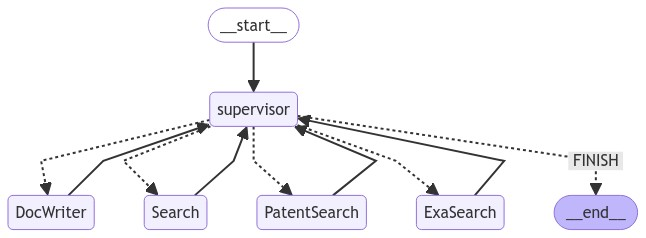

In [ ]:
display(Image(chain.get_graph().draw_mermaid_png()))

In [ ]:
for s in authoring_chain.stream(
    """Write a 800 words long research report white paper on semiconductor development which
    includes an executive summary at the beginning about your findings.
    Search also for relevant recent patents and include the links to it.
    IMPORTANT: Provide the links to all your sources, and then write the report to disk as .txt file.""",
    {"recursion_limit": 100},
):
    if "__end__" not in s:
        print(s)
        print("---")

{'supervisor': {'next': 'Search'}}
---
{'Search': {'messages': [HumanMessage(content='### Executive Summary\n\nThe semiconductor industry continues to be a cornerstone of technological progress, with global sales reaching $574 billion in 2022 and projected to surpass $1 trillion by 2030. The year 2023 has seen remarkable advancements including the development of thermal transistors and significant investments in workforce development in the U.S., propelled by the CHIPS and Science Act. Major players like Samsung, Huawei, IBM, Qualcomm, and LG dominate the patent landscape, with a significant number of patents being filed and granted in semiconductor technology. The industry is characterized by both rapid innovation and extensive patent activity, making it a crucial area for technological and economic growth.\n\n### Semiconductor Development: A 2023 Overview\n\n#### Introduction\n\nThe semiconductor industry, often referred to as the backbone of modern technology, has seen unprecedented

# Result Report

# White Paper: Recent Developments in Semiconductor Industry

## Executive Summary

The semiconductor industry has seen substantial advancements and growth in 2023. This year has been marked by record-breaking sales, significant technological innovations, and challenges in supply chain management. The global semiconductor market is projected to surpass $1 trillion by 2030, driven by demands from various sectors including computing, data storage, wireless communication, and automotive electronics. Key innovations such as thermal transistors and advancements in AI applications have been highlighted, showcasing the industry's progressive technological landscape. Additionally, recent patent data reveals a surge in semiconductor-related patents, indicating a robust pipeline of future innovations. This report delves into these developments, discussing the current state of the industry, technological breakthroughs, and the strategic directions companies are taking to navigate this dynamic environment.

## Introduction

The semiconductor industry is a critical component of the global economy, underpinning advancements in technology across multiple sectors. In recent years, the industry has experienced rapid growth and innovation, driven by increasing demands for more powerful and efficient computing solutions. This report provides an overview of the recent developments in the semiconductor industry, including market trends, technological advancements, and recent patent filings.

## Market Trends and Growth

In 2022, global semiconductor sales reached an all-time high of \$574 billion, and the market is projected to surpass \$1 trillion by 2030. This growth is fueled by increasing demands from computing and data storage, wireless communication, and automotive electronics. Companies are diversifying their supply chain geographies to mitigate risks and ensure steady growth. Despite facing both shortages and oversupply challenges, the industry remains optimistic about future growth.

*Source:* [USITC Executive Briefing](https://www.usitc.gov/publications/332/executive_briefings/ebot_recent_developments_in_global_semiconductor_industry.pdf)

## Technological Innovations

### Thermal Transistors

One of the groundbreaking achievements in 2023 is the advent of thermal transistors. These devices leverage temperature differences to control electrical current, offering potential benefits in terms of energy efficiency and performance. This innovation represents a significant leap forward in semiconductor technology, promising to enhance the capabilities of electronic devices.

*Source:* [McKinsey Electronics](https://www.mckinsey-electronics.com/post/2023-biggest-semiconductor-inventions-discoveries)

### AI and Semiconductor Integration

Artificial Intelligence (AI) continues to be a major driver of innovation within the semiconductor industry. In 2023, AI-related semiconductor patents surged, reflecting the industry's focus on integrating AI capabilities into semiconductor devices. These advancements are expected to revolutionize sectors such as healthcare, automotive, and consumer electronics, providing smarter and more efficient solutions.

*Source:* [Semiconductor Digest](https://www.semiconductor-digest.com/semiconductor-tech-received-most-granted-patents-in-2023/)

## Supply Chain and Talent Management

The semiconductor industry faces significant challenges in supply chain management and talent acquisition. The global supply chain disruptions caused by the pandemic have led companies to invest in advanced software and analytics to track products and solutions. Additionally, there is a growing demand for specialized skills in areas such as smart factory automation, electrical engineering, and maintenance.

*Source:* [Deloitte Semiconductor Industry Outlook](https://www2.deloitte.com/content/dam/Deloitte/us/Documents/technology-media-telecommunications/us-tmt-semiconductor-industry-outlook.pdf)

## Recent Patent Activity

The semiconductor industry has seen a remarkable increase in patent filings over the past year. In 2023, Samsung Electronics led with over 10,000 patents, followed by companies like IBM, Qualcomm, and Taiwan Semiconductor Manufacturing Company. These patents cover a wide range of technologies, from AI integration to advanced manufacturing processes.

*Source:* [World IP Review](https://www.worldipreview.com/semiconductors-and-vr-lead-marginal-increase-in-us-patents-in-2023-24648), [Mathys & Squire](https://www.mathys-squire.com/insights-and-events/news/semiconductor-patents-rise-by-59-in-five-years-to-reach-to-record-high/)

## Conclusion

The semiconductor industry is poised for continued growth and innovation, driven by increasing demands and technological advancements. While challenges such as supply chain management and talent acquisition persist, the industry's robust pipeline of innovations and strategic initiatives indicate a promising future. As companies continue to invest in research and development, the semiconductor industry will play a pivotal role in shaping the future of technology.

## References

1. [USITC Executive Briefing](https://www.usitc.gov/publications/332/executive_briefings/ebot_recent_developments_in_global_semiconductor_industry.pdf)
2. [McKinsey Electronics](https://www.mckinsey-electronics.com/post/2023-biggest-semiconductor-inventions-discoveries)
3. [Deloitte Semiconductor Industry Outlook](https://www2.deloitte.com/content/dam/Deloitte/us/Documents/technology-media-telecommunications/us-tmt-semiconductor-industry-outlook.pdf)
4. [Semiconductor Digest](https://www.semiconductor-digest.com/semiconductor-tech-received-most-granted-patents-in-2023/)
5. [World IP Review](https://www.worldipreview.com/semiconductors-and-vr-lead-marginal-increase-in-us-patents-in-2023-24648)
6. [Mathys & Squire](https://www.mathys-squire.com/insights-and-events/news/semiconductor-patents-rise-by-59-in-five-years-to-reach-to-record-high/)
